In [43]:
!pip install scikit-learn
!pip install nltk
!pip install torch

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 2.9/241.4 MB 28.2 MB/s eta 0:00:09
   - -------------------------------------- 11.5/241.4 MB 38.0 MB/s eta 0:00:07
   --- ------------------------------------ 22.3/241.4 MB 42.8 MB/s eta 0:00:06
   ----- ---------------------------------- 34.6/241.4 MB 47.8 MB/s eta 0:00:05
   ------- -------------------------------- 46.4/241.4 MB 49.2 MB/s eta 0:00:04
   --------- ------------------------------ 60.0/241.4 MB 51.7 MB/s eta 0:00:04
   ----------- ---------------------------- 71.6/241.4 MB 51.9 MB/s eta 0:00:04
   -------------- ------------------------- 85.2/241.4 MB 53.3 MB/s eta 0:00:03
   --------------- ------------------------ 95.9/241.4 MB 53.2 MB/s eta 0:00:03
   ----------------- -

In [50]:
import numpy as np
import json
import re
import collections
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manhh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\manhh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
with open('intents.json', 'r') as f:
    intents = json.load(f)

In [ ]:
tags = []
symsptoms = []
xy = []
all_words = []
for intent in intents['intents']:
    tags = intent['tag']
    for pattern in intent['patterns']:
        all_words.extend(word_tokenize(pattern))
        xy.append((pattern, tags))

In [12]:
def cleaning_sentence(sentence):
    if sentence is None:
        return ""
    sentence = sentence.lower().strip()
    sentence = re.sub(r'\d+', '', sentence)
    sentence = re.sub(r'[^a-z A-Z]','', sentence)
    return sentence

In [13]:
xy_clean = [(cleaning_sentence(pattern), cleaning_sentence(tag)) for (pattern, tag) in xy]

## Khám phá

In [14]:
len(xy)

2180

In [15]:
xy = [(pattern, tag) for (pattern, tag) in xy if pattern is not None and tag is not None]
len(xy)

2177

In [16]:
counts = collections.Counter([tag for _, tag in xy])
counts

Counter({'who': 8,
         'Asthma': 7,
         'Rheumatoid Arthritis': 7,
         'greeting': 6,
         'Common Cold': 6,
         'Arthritis': 6,
         'Hypothyroidism': 6,
         'Hypoglycemia': 6,
         'Panic disorder': 6,
         'Fracture': 6,
         'Pyloric stenosis': 6,
         'Choledocholithiasis': 6,
         'Bronchial Asthma': 5,
         'Type 2 Diabetes': 5,
         'Osteoarthritis': 5,
         'Urinary Tract Infection (UTI)': 5,
         'Chicken pox': 5,
         'Pneumonia': 5,
         'Hyperthyroidism': 5,
         'Varicose Veins': 5,
         'Vocal cord polyp': 5,
         'Turner syndrome': 5,
         'Cellulitis': 5,
         'Breast Cancer': 5,
         'work': 4,
         'Thanks': 4,
         'Allergies': 4,
         'Diabetes': 4,
         'Migraine': 4,
         'Anxiety': 4,
         'Hepatitis A': 4,
         'Hepatitis B': 4,
         'Hepatitis D': 4,
         'Psoriasis': 4,
         'Heart Attack': 4,
         'Lupus': 4,
      

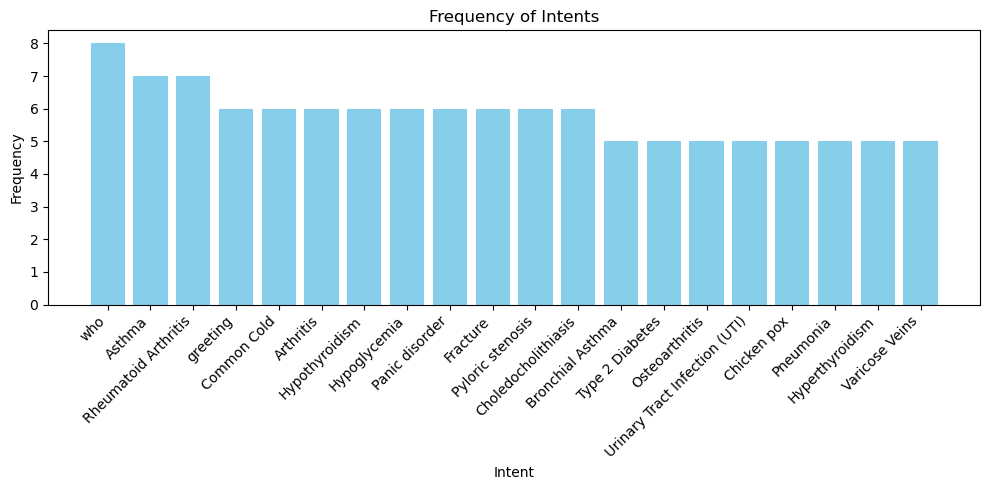

In [17]:
labels, values = zip(*counts.most_common(20))

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Intent')
plt.ylabel('Frequency')
plt.title('Frequency of Intents')
plt.tight_layout()
plt.show()

In [18]:
texts = [pattern for (pattern, tag) in xy]
labels = [tag for (pattern, tag) in xy]

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

## Tokenization

In [ ]:
def tokenize(texts):
    return [word_tokenize(text) for text in texts]  

In [25]:
X_train_tok = tokenize(X_train)
X_val_tok   = tokenize(X_val)
X_test_tok  = tokenize(X_test)

## Embedding

In [39]:
all_tokens = [token for sentence in X_train_tok for token in sentence]
vocab = list(set(all_tokens))
word2idx = {word: idx+1 for idx, word in enumerate(vocab)}  # +1 để dành 0 cho padding
word2idx['<PAD>'] = 0  # padding
word2idx['<UNK>'] = len(word2idx)

In [ ]:
def tokens_to_indices(tokenized_sentences, word2idx):
    return [
        [word2idx.get(token, word2idx['<UNK>']) for token in sentence]
        for sentence in tokenized_sentences
    ]

X_train_idx = tokens_to_indices(X_train_tok, word2idx)
X_val_idx   = tokens_to_indices(X_val_tok, word2idx)
X_test_idx  = tokens_to_indices(X_test_tok, word2idx)

In [46]:
def pad_sentences(indexed_sentences, max_len=None):
    tensor_sentences = [torch.tensor(s) for s in indexed_sentences]
    if max_len:
        tensor_sentences = [s[:max_len] for s in tensor_sentences]
    return pad_sequence(tensor_sentences, batch_first=True, padding_value=word2idx['<PAD>'])

X_train_pad = pad_sentences(X_train_idx)
X_val_pad   = pad_sentences(X_val_idx, max_len=X_train_pad.size(1))
X_test_pad  = pad_sentences(X_test_idx, max_len=X_train_pad.size(1))